# 使用卷积神经网络的垃圾分类模型之二

In [37]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import globalConfig.config as config
import pathlib

## 查看 GPU 支持

In [38]:
gpus = tf.config.list_physical_devices(device_type='GPU')
cpus = tf.config.list_physical_devices(device_type='CPU')
print(gpus, cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 准备原始图片

参数：

In [39]:

dataDir = pathlib.Path(config.modelMulClassi.dataDir)

## 分割数据集

图片统一缩放到 180 x 180 x colorChannel

每个样本集取默认值 32

参数：

In [40]:
imgHeight = config.modelMulClassi.imgHeight
imgWidth = config.modelMulClassi.imgWidth
batchSize = config.modelMulClassi.batchSize

In [41]:
trainDataset = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize
)
valDataset = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize
)
classNames = trainDataset.class_names
f'labels {classNames}'

Found 2970 files belonging to 5 classes.
Using 2376 files for training.
Found 2970 files belonging to 5 classes.
Using 594 files for validation.


"labels ['cardboard', 'glass', 'metal', 'paper', 'plastic']"

以第一个样本集为例

In [42]:
# plt.figure(figsize=(22, 12))
# for images, labels in trainDataset.take(1):
#   for i in range(1, 33):
#     ax = plt.subplot(4, 8, i)
#     plt.imshow(images[i - 1].numpy().astype("uint8"))
#     plt.title(classNames[labels[i - 1]])

将数据集缓存在内存

In [43]:
trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valDataset = valDataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## 模型创建

In [44]:
modelConfiguration = [ keras.layers.InputLayer(input_shape=(imgHeight, imgWidth, 3)) ]

### 数据增强层

这一层用来对数据进行随机的平移、旋转和缩放，增强模型的泛化能力，这是减少过拟合措施的一部分。

In [45]:
modelConfiguration.extend([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

### 输入规范化层

将每个 colorChannel [0, 255] -> [0, 1]

另外，输入的数据集已经在 `tf.keras.utils.image_dataset_from_directory` 做过预处理缩放，所以不需要再加入缩放层

In [46]:
modelConfiguration.append(keras.layers.Rescaling(1. / 255))
# modelConfiguration.append(tf.keras.layers.Resizing(imgHeight, imgWidth))

### 卷积、池化层

包含三个卷积核大小为 3 的二维卷积块，

在每个二维卷积块处理后紧邻一个最大池化层来提取合并特征。

In [47]:
modelConfiguration.extend([
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
])

### 过渡层

从最后一个最大池化层处理后，我们输出的三维特征在一维展平

但在此之前，我们向网络中引入 dropout 正则化，让每次训练时随机忽略一部分神经元。换句话讲，这些神经元在正向传播时对下游的启动影响被忽略，反向传播时也不会更新权重。

In [48]:
modelConfiguration.extend([
    keras.layers.Dropout(0.4),
    keras.layers.Flatten()
])

### 全连接层

这可以让网络对某个神经元的权重变化更不敏感，增加泛化能力，这是减少过拟合措施的一部分。

然后经过一个 128 个单元的全连接网络层，进行对输出特征的分类，最后再经过一个 Dropout 层，

最终在一个包含 label 数量的全连接层输出结果向量，作为分类结果。

In [49]:
modelConfiguration.extend([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(len(classNames))
])

### 编译模型

In [50]:
model = keras.models.Sequential(modelConfiguration)
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                  

## 训练

优化方法选择 Adam，它是一种基于一阶和二阶矩自适应估计的随机梯度下降方法。

损失函数通过预测和标签之间的交叉熵损失提供梯度，由 `SparseCategoricalCrossentropy` 调用提供。

参数：

In [51]:
epochs=config.modelMulClassi.epochs

In [52]:
history = model.fit(
    trainDataset,
    validation_data=valDataset,
    epochs=epochs
)

Epoch 1/30
75/75 [==============================] - 34s 111ms/step - loss: 1.6459 - accuracy: 0.2955 - val_loss: 1.3417 - val_accuracy: 0.4394
Epoch 2/30
75/75 [==============================] - 2s 24ms/step - loss: 1.3937 - accuracy: 0.3847 - val_loss: 1.2923 - val_accuracy: 0.4714
Epoch 3/30
75/75 [==============================] - 2s 23ms/step - loss: 1.2901 - accuracy: 0.4499 - val_loss: 1.1734 - val_accuracy: 0.5354
Epoch 4/30
75/75 [==============================] - 2s 24ms/step - loss: 1.2222 - accuracy: 0.4794 - val_loss: 1.1822 - val_accuracy: 0.4461
Epoch 5/30
75/75 [==============================] - 2s 24ms/step - loss: 1.1789 - accuracy: 0.5139 - val_loss: 1.0827 - val_accuracy: 0.5640
Epoch 6/30
75/75 [==============================] - 2s 24ms/step - loss: 1.1187 - accuracy: 0.5379 - val_loss: 1.0868 - val_accuracy: 0.6027
Epoch 7/30
75/75 [==============================] - 2s 24ms/step - loss: 1.0988 - accuracy: 0.5425 - val_loss: 1.1142 - val_accuracy: 0.5606
Epoch 8/30


## 训练表现

查看在训练集和验证集上的精确度和损失表现

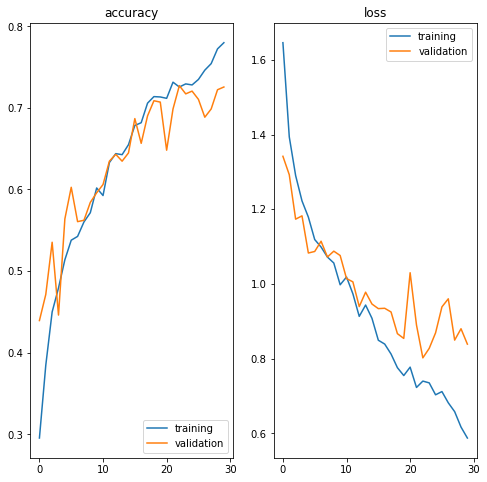

In [53]:
acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

loss = history.history['loss']
valLoss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='training')
plt.plot(epochs_range, valAcc, label='validation')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='training')
plt.plot(epochs_range, valLoss, label='validation')
plt.legend(loc='upper right')
plt.title('loss')
plt.show()

可以看出，在我们使用了数据增强和 dropout 层后，验证集的准确率和损失很好地收敛在了训练集附近，模型的拟合效果不错。

## 持久化神经网络权值

In [54]:
modelConfig = config.modelMulClassi
if not os.path.exists(modelConfig.savedDir):
    os.makedirs(modelConfig.savedDir)

model.save_weights(os.path.join(modelConfig.savedDir, modelConfig.savedName))